In [1]:
import os

import pandas as pd
import torch
from torchvision import datasets , transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from src.models.cnn import CNN
from src.utility.generate_images import makeSyntheticTrain
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Data Transformation

In [2]:
# transformation to the image dataseet:
transforms_minimal = v2.Compose(
    [
        transforms.ToTensor(),
        v2.Grayscale(num_output_channels=1),
        v2.Resize((128, 128))  # Resize to a fixed size
    ]
)

transforms_basic = v2.Compose(
    [
        transforms.ToTensor(),
        v2.Grayscale(num_output_channels=1),
        v2.RandomHorizontalFlip(p=0.5),
        v2.Resize((128, 128))  # Resize to a fixed size
    ]
)

transforms_auto = v2.Compose(
    [
        transforms.ToTensor(),
        v2.Grayscale(num_output_channels=1),
        v2.AutoAugment(policy=v2.AutoAugmentPolicy.IMAGENET),
        v2.Resize((128, 128))  # Resize to a fixed size
    ]
)


#### Train Model

In [3]:
def train_model(
        train_dir,
        test_dir,
        train_perc,
        synthetic_perc,
        transform,
        transform_name
):
    # load images
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    # create dataloader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    # Split the dataset into training and validation sets (80-20 split)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Initialize the model
    model = CNN(in_channels=1, num_classes=4)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # train model
    best_val_loss = float('inf')
    patience = 2  # Number of epochs to wait for improvement before stopping
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []
    num_epochs=10

    for epoch in range(num_epochs):
        
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_corrects.double() / len(val_loader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), 'best_model.pth') # Save the model
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation loss.")
            break
        
    # store results in dataframe
    dat = {
        "train_percentage":[train_perc]*len(val_losses),
        "synthetic_percentage":[synthetic_perc]*len(val_losses),
        "transform":transform_name,
        "epoch": range(len(val_losses)),
        "val_losses": val_losses,
        "train_losses": train_losses,
        "val_accuracies": [acc.item() for acc in val_accuracies]
    }

    result_df = pd.DataFrame(data=dat)

    return result_df

In [4]:
train_dir = "data/alzheimer_mri/train"
test_dir = "data/alzheimer_mri/test"
synthetic_dir = "data/alzheimer_mri/synthetic_train"
n_sims = 100

df_all_results = pd.DataFrame(columns = [
    "sim_num","train_percentage","synthetic_percentage","transform",
    "epoch","val_losses","train_losses","val_accuracies"
])

for train_perc, synthetic_perc in zip(
    [0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0],
    [0.0, 0.6, 0.0, 0.4, 0.0, 0.2, 0.0, 0.2]
    ):

    for transform, transform_name in zip(
        [transforms_minimal, transforms_basic, transforms_auto],
        ['minimal','basic','auto']
        ):
        
            for n in range(n_sims):
                
                # make synthetic + real mix
                makeSyntheticTrain(train_dir, synthetic_dir, train_perc, synthetic_perc)
                
                df_sim_results = train_model(
                    train_dir = train_dir,
                    test_dir = synthetic_dir,
                    train_perc = train_perc,
                    synthetic_perc = synthetic_perc,
                    transform = transform,
                    transform_name = transform_name
                )

                df_sim_results["sim_num"] = n

                df_all_results = pd.concat([df_all_results, df_sim_results],ignore_index=True)

    df_all_results.to_csv(f"results/sim_results_train{str(train_perc*10).replace('.','')}_synth{str(synthetic_perc*10).replace('.','')}.csv")

Epoch 1/10, Train Loss: 1.0637, Val Loss: 0.9885, Val Accuracy: 0.49609375
Epoch 2/10, Train Loss: 0.9751, Val Loss: 0.9633, Val Accuracy: 0.505859375
Epoch 3/10, Train Loss: 0.8960, Val Loss: 0.8432, Val Accuracy: 0.60546875
Epoch 4/10, Train Loss: 0.8028, Val Loss: 0.7609, Val Accuracy: 0.6376953125
Epoch 5/10, Train Loss: 0.6571, Val Loss: 0.6342, Val Accuracy: 0.7265625
Epoch 6/10, Train Loss: 0.4727, Val Loss: 0.4727, Val Accuracy: 0.791015625
Epoch 7/10, Train Loss: 0.3254, Val Loss: 0.3716, Val Accuracy: 0.8466796875
Epoch 8/10, Train Loss: 0.2032, Val Loss: 0.2699, Val Accuracy: 0.892578125
Epoch 9/10, Train Loss: 0.1213, Val Loss: 0.2034, Val Accuracy: 0.921875
Epoch 10/10, Train Loss: 0.0773, Val Loss: 0.1806, Val Accuracy: 0.94140625


/var/tmp/ipykernel_1004137/2308774993.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_results = pd.concat([df_all_results, df_sim_results],ignore_index=True)


Epoch 1/10, Train Loss: 1.0487, Val Loss: 1.0129, Val Accuracy: 0.4931640625
Epoch 2/10, Train Loss: 0.9664, Val Loss: 0.9327, Val Accuracy: 0.51953125
Epoch 3/10, Train Loss: 0.8937, Val Loss: 0.8456, Val Accuracy: 0.5830078125
Epoch 4/10, Train Loss: 0.7947, Val Loss: 0.8441, Val Accuracy: 0.5810546875
Epoch 5/10, Train Loss: 0.6497, Val Loss: 0.6347, Val Accuracy: 0.7119140625
Epoch 6/10, Train Loss: 0.4607, Val Loss: 0.5821, Val Accuracy: 0.7685546875
Epoch 7/10, Train Loss: 0.3080, Val Loss: 0.4256, Val Accuracy: 0.8251953125
Epoch 8/10, Train Loss: 0.1949, Val Loss: 0.2874, Val Accuracy: 0.896484375
Epoch 9/10, Train Loss: 0.1152, Val Loss: 0.4026, Val Accuracy: 0.861328125
Epoch 10/10, Train Loss: 0.0958, Val Loss: 0.3274, Val Accuracy: 0.88671875
Stopping early due to no improvement in validation loss.
Epoch 1/10, Train Loss: 1.0378, Val Loss: 0.9698, Val Accuracy: 0.548828125
Epoch 2/10, Train Loss: 0.9292, Val Loss: 0.9447, Val Accuracy: 0.5146484375
Epoch 3/10, Train Loss: 0

In [5]:
df_results = pd.DataFrame()
for f in os.listdir('results/'):
    df_results = pd.concat((df_results,pd.read_csv(f'results/{f}')))

In [6]:
df_results['category'] = df_results['transform'] + '_' + df_results['train_percentage'].astype(str) + '_' +  df_results['synthetic_percentage'].astype(str)

In [16]:
df_results[df_results['category'].isin(['minimal_0.4_0.6','minimal_0.6_0.0','minimal_0.8_0.0'])]

,Unnamed: 0,sim_num,train_percentage,synthetic_percentage,transform,epoch,val_losses,train_losses,val_accuracies,category
0,0,0,0.4,0.0,minimal,0,0.934176,1.026187,0.509766,minimal_0.4_0.0
1,1,0,0.4,0.0,minimal,1,0.898855,0.897241,0.627930,minimal_0.4_0.0
2,2,0,0.4,0.0,minimal,2,0.889469,0.807688,0.589844,minimal_0.4_0.0
3,3,0,0.4,0.0,minimal,3,0.645930,0.651429,0.708008,minimal_0.4_0.0
4,4,0,0.4,0.0,minimal,4,0.500435,0.453946,0.795898,minimal_0.4_0.0
...,...,...,...,...,...,...,...,...,...,...
25,25,2,0.4,0.0,minimal,5,0.545492,0.460601,0.788086,minimal_0.4_0.0
26,26,2,0.4,0.0,minimal,6,0.370285,0.314923,0.860352,minimal_0.4_0.0
27,27,2,0.4,0.0,minimal,7,0.324593,0.201999,0.870117,minimal_0.4_0.0
28,28,2,0.4,0.0,minimal,8,0.208953,0.101098,0.925781,minimal_0.4_0.0


<Axes: xlabel='epoch', ylabel='val_losses'>

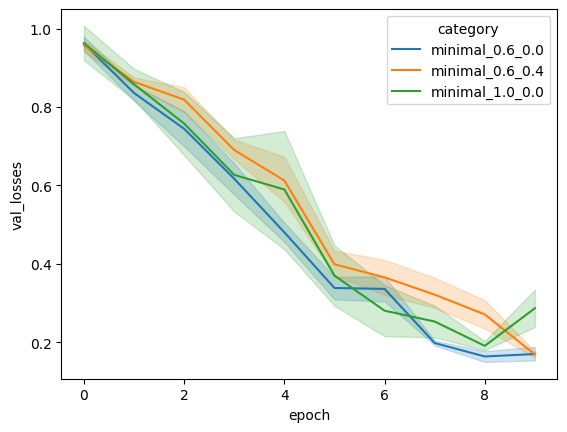

In [61]:
import seaborn as sns
transform_category = 'minimal'
sns.lineplot(
    data=df_results[df_results['category'].isin([f'{transform_category}_1.0_0.0',f'{transform_category}_0.6_0.4',f'{transform_category}_0.6_0.0'])],
    x='epoch',
    y='val_losses',
    hue='category'
)

In [68]:
df_results[df_results['category'].isin([f'{transform_category}_1.0_0.0',f'{transform_category}_0.6_0.4',f'{transform_category}_0.6_0.0'])].groupby(['sim_num','category']).min().reset_index()

,sim_num,category,Unnamed: 0,train_percentage,synthetic_percentage,transform,epoch,val_losses,train_losses,val_accuracies
0,0,minimal_0.6_0.0,167,0.6,0.0,minimal,0,0.159997,0.005090,0.571289
1,0,minimal_0.6_0.4,244,0.6,0.4,minimal,0,0.185607,0.082960,0.513672
2,0,minimal_1.0_0.0,498,1.0,0.0,minimal,0,0.213179,0.078233,0.492188
3,1,minimal_0.6_0.0,177,0.6,0.0,minimal,0,0.202689,0.036439,0.528320
4,1,minimal_0.6_0.4,254,0.6,0.4,minimal,0,0.173636,0.042937,0.550781
5,1,minimal_1.0_0.0,508,1.0,0.0,minimal,0,0.183660,0.062627,0.538086
6,2,minimal_0.6_0.0,187,0.6,0.0,minimal,0,0.125126,0.019936,0.591797
7,2,minimal_0.6_0.4,264,0.6,0.4,minimal,0,0.148514,0.048877,0.521484
8,2,minimal_1.0_0.0,518,1.0,0.0,minimal,0,0.176274,0.011665,0.571289


<Axes: xlabel='val_losses', ylabel='Count'>

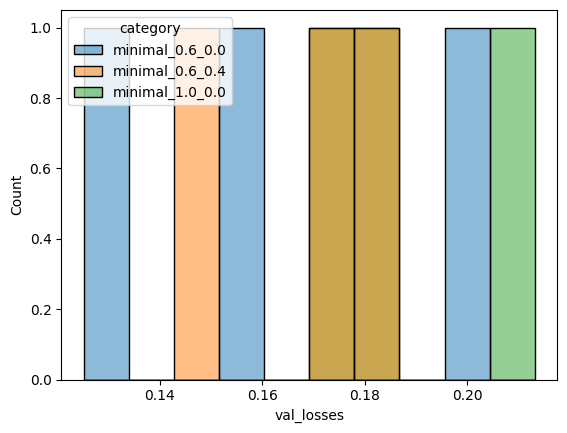

In [67]:
sns.histplot(
    data=df_results[df_results['category'].isin([f'{transform_category}_1.0_0.0',f'{transform_category}_0.6_0.4',f'{transform_category}_0.6_0.0'])].groupby(['sim_num','category']).min().reset_index(),
    x='val_losses',
    hue='category',
    bins=10
)